Import dependencies 

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from keras.optimizers import RMSprop, SGD
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from keras.utils.np_utils import to_categorical
from keras.callbacks import ReduceLROnPlateau

plt.rcParams["figure.figsize"] = (15,5)

# (1) Read in and explore the data

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [3]:
print('x_train shape: {}'.format(x_train.shape))
print('y_train shape: {}'.format(y_train.shape))

x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)


Plot the distribution of labels

In [4]:
y_train[0:5]

array([[6],
       [9],
       [9],
       [4],
       [1]], dtype=uint8)

The class labels are in integer form. I will create a dict relating each class to its relevant integer.

In [5]:
image_numbers = {0:'airplane', 1:'automobile',2:'bird',3:'cat',4:'deer',5:'dog',6:'frog',7:'horse',8:'ship',9:'truck'}

Lets have a look to see if the class distributions in the dataset are balanced

Text(0.5, 1.0, 'Distribution of training set')

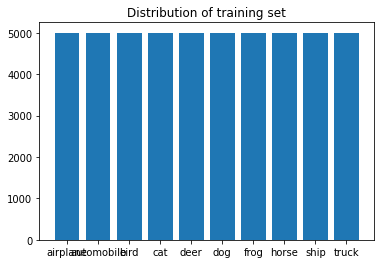

In [6]:
classes, counts = np.unique(y_train, return_counts=True)
names = np.vectorize(image_numbers.get)(classes)

plt.bar(names, counts)
plt.title('Distribution of training set')

We have a perfectly balanced dataset here. This allows us to appropriately use accuracy as an evaluation metric.

Lets have a look at some images from each class. Given the low resolution of this data (32 x 32), certain images present a difficult classification task even for humans.

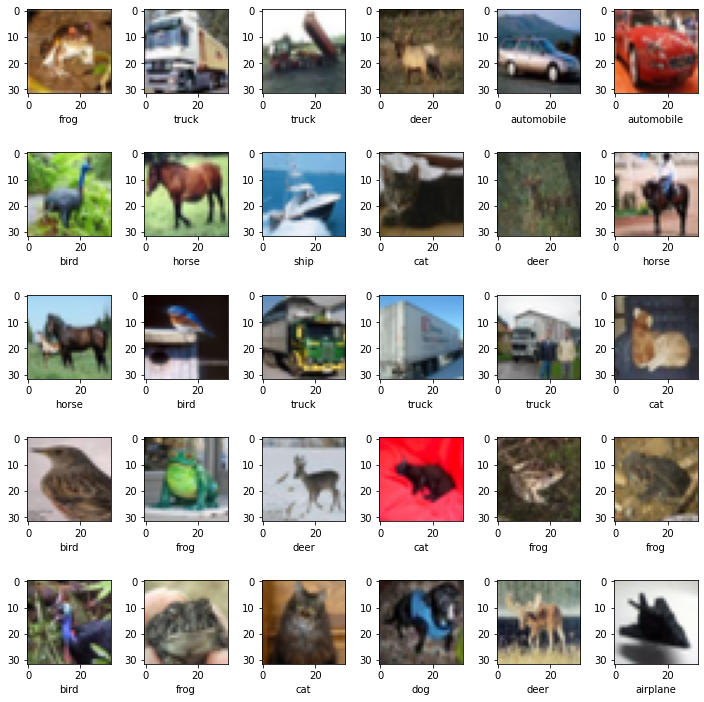

In [7]:
fig = plt.figure(figsize=(10,10))
for i in range(30):
    plt.subplot(5,6, i+1)
    plt.tight_layout()
    plt.imshow(x_train[i], cmap = 'gray', interpolation=None)
    plt.xlabel(names[int(y_train[i])])

# (2) Preprocess the data

The data consists of pixel values between 0 and 255. I will simply divide each pixel by 255 to normalise the data between 0 and 1.

In [8]:
x_train = x_train/255
x_test = x_test/255

Next lets one hot encode the target variables 

In [9]:
y_train.shape

(50000, 1)

In [10]:
y_train = to_categorical(y_train, num_classes = 10)
y_test = to_categorical(y_test, num_classes = 10)
y_train.shape

(50000, 10)

# (3) Build and evaluate model

Lets start by splitting the data, 80% training : 20% validation

In [11]:
X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train, test_size = 0.2, random_state=1)

Define sequential model with convolutional base and dense head.

In [12]:
model = models.Sequential()

model.add(layers.Conv2D(filters = 32, kernel_size=(3,3), activation='relu', padding='Same', input_shape = x_train[0].shape))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(filters = 32, kernel_size=(3,3), activation='relu', padding='Same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D(2,2))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(filters = 32, kernel_size=(3,3), activation='relu', padding='Same'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(filters = 64, kernel_size=(3,3), activation='relu', padding='Same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D(2,2))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(filters = 128, kernel_size=(3,3), activation='relu', padding='Same'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(filters = 256, kernel_size=(3,3), activation='relu', padding='Same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D(2,2))
model.add(layers.Dropout(0.2))


model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

Define optimizer, loss function and evaluation metric

In [13]:
model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=["accuracy"])

In [14]:
epochs = 60
batch_size = 32

Add an early stopping callback function

In [15]:
cb = EarlyStopping(
     min_delta=0,
     monitor='val_loss',
     patience=12,
     restore_best_weights=True
)

Make random image augmentations each batch

In [16]:
datagen = ImageDataGenerator(
        width_shift_range=0.1,  
        height_shift_range=0.1,  
        horizontal_flip=True,  
        vertical_flip=False)  

Fit model

In [17]:
history = model.fit(datagen.flow(X_train, Y_train, batch_size), epochs = epochs, validation_data = (X_val, Y_val), callbacks=[cb])

Epoch 1/60
1250/1250 [==============================] - 22s 16ms/step - loss: 1.8984 - accuracy: 0.3130 - val_loss: 1.4099 - val_accuracy: 0.4982
Epoch 2/60
1250/1250 [==============================] - 20s 16ms/step - loss: 1.4114 - accuracy: 0.4900 - val_loss: 1.3533 - val_accuracy: 0.5259
Epoch 3/60
1250/1250 [==============================] - 20s 16ms/step - loss: 1.1810 - accuracy: 0.5811 - val_loss: 0.9802 - val_accuracy: 0.6552
Epoch 4/60
1250/1250 [==============================] - 20s 16ms/step - loss: 1.0266 - accuracy: 0.6401 - val_loss: 1.0383 - val_accuracy: 0.6366
Epoch 5/60
1250/1250 [==============================] - 20s 16ms/step - loss: 0.9182 - accuracy: 0.6821 - val_loss: 0.8077 - val_accuracy: 0.7296
Epoch 6/60
1250/1250 [==============================] - 20s 16ms/step - loss: 0.8589 - accuracy: 0.7044 - val_loss: 0.8445 - val_accuracy: 0.7151
Epoch 7/60
1250/1250 [==============================] - 20s 16ms/step - loss: 0.8045 - accuracy: 0.7273 - val_loss: 0.6849 -

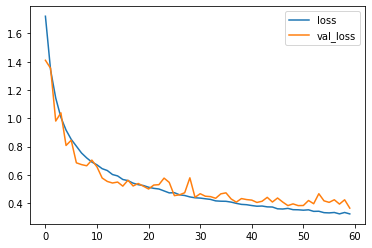

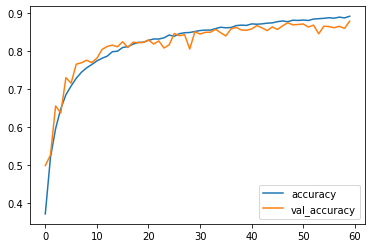

In [18]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

Evaluate our model on test data

In [19]:
test_loss, test_acc = model.evaluate(x_test,  y_test)
print('Accuracy on test data: {:.2f}%'.format(test_acc*100))
print('Loss on test data: {:.2f}'.format(test_loss))

313/313 [==============================] - 1s 3ms/step - loss: 0.3822 - accuracy: 0.8754
Accuracy on test data: 87.54%
Loss on test data: 0.38


# (4) Summary of results

In [20]:
predictions=model.predict_classes(x_test)
predictions

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([3, 8, 8, ..., 5, 1, 7])

In [21]:
predictions[0:15]

array([3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9])

Convert y_test back to 1D array

In [22]:
print(y_test.shape)
y_test=y_test.argmax(1)
print(y_test.shape)

(10000, 10)
(10000,)


In [23]:
y_test[0:15]

array([3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9])

Find indexes of misclassified images

In [24]:
misclassified = [index for index,(i,j) in enumerate(zip(predictions, y_test)) if  i != j]

(len(y_test) - len(misclassified))*0.01

87.54

Lets have a look at some Images our model failed to classify correctly.

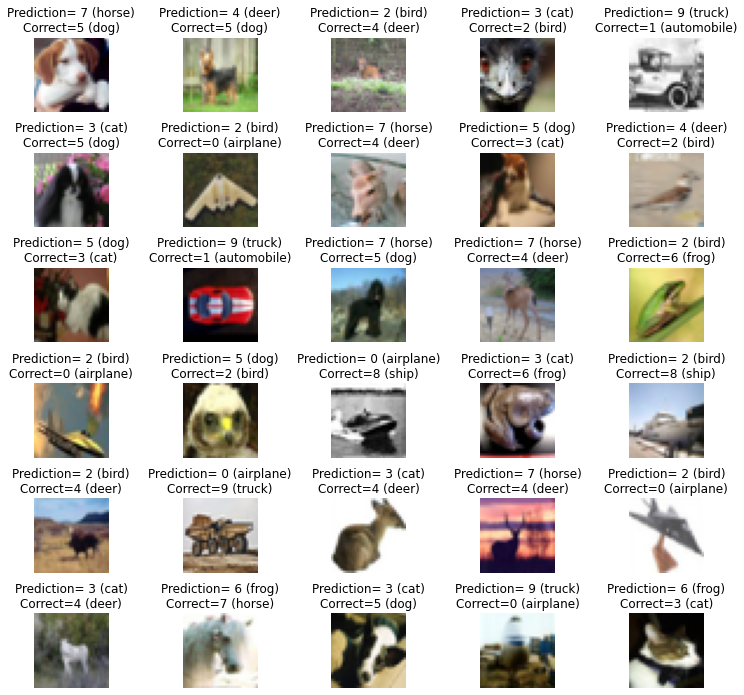

In [25]:
L=6
W=5
fig,axes=plt.subplots(L,W,figsize=(12,12))
axes=axes.ravel()
for index,k in enumerate(misclassified[0:L*W]):
    axes[index].imshow(x_test[k])
    axes[index].set_title('Prediction= {} ({})\nCorrect={} ({})'.format(predictions[k], image_numbers[predictions[k]], y_test[k], image_numbers[y_test[k]]))
    axes[index].axis('off')
    plt.subplots_adjust(wspace=1)
    plt.subplots_adjust(hspace=0.5)

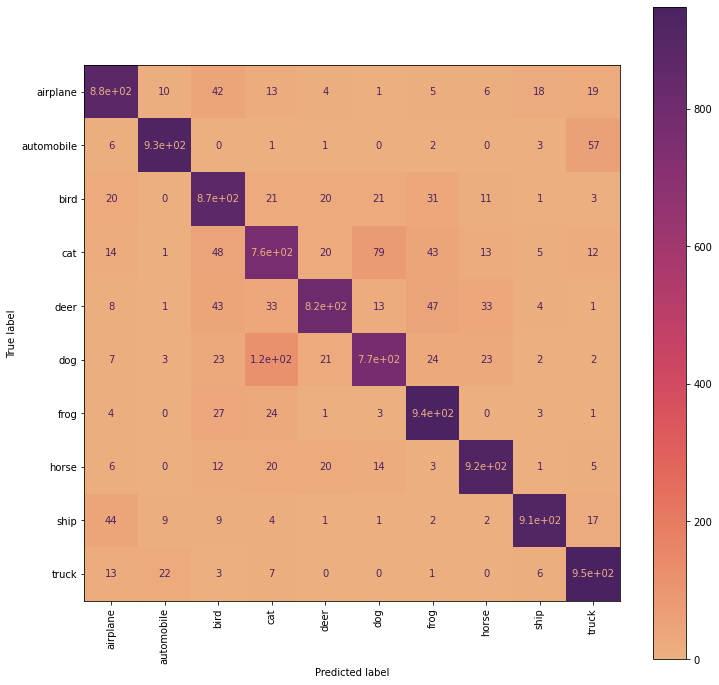

In [26]:
cm= confusion_matrix(y_test,predictions)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=names)

fig, ax = plt.subplots(figsize=(12, 12))
display = display.plot(xticks_rotation='vertical', ax=ax,cmap='flare')

plt.show()

Looking at the confusion matrix, the model performed best as classifying automobiles, frogs and trucks. In contrast, it struggled most at classifying cats, dogs and deers.

The two significant errors evident from the confusion matrix are in the misclassification of cats and dogs, vice versa. To improve this, I would use a transfer learning approach with perhaps one of the big VGG models that would better extract distict features of cats Vs Dogs, aswell as the other classes. All in all a good results on the given dataset.